# Modeling Dialogue in Star Wars

## 1 Introduction

Star Wars is decidedly the most well-known and beloved epic space movie franchise ever created. With the first movie airing more than 40 years ago, the series has since released eight more immensely successful films and still continue to develop the entertaining storyline. 

A fascinating aspect of the movies is the array of languages spoken by the characters. There is plenty of dialogue featured in the movies that is not spoken in natural language. A few of these languages include Galactic Basic, Shyriiwook (spoken by Chewbacca), droidspeak (spoken by R2D2), and Huttese (spoken by Jabba the Hutt). The detailed linguistic side of Star Wars begs further exploration and analysis, and is what this project concerns.

Anyone who has seen just one of the Star Wars movies knows that the plot can be summarized very broadly as the struggle between the Galactic Empire and the Rebel Alliance. After exploring a dataset of the dialogue from the first three episodes of Star Wars I came across on Kaggle, I wanted to examine the difference in spoken language between characters who side with the Empire and characters who fight for the Rebels.

Using feature extraction, topic modeling, named entity recognition, machine learning and more, in this project I build a model which can **predict with up to 87% accuracy whether or not a certain line of dialogue from the first three episodes of Star Wars (four, five, and six) is said by a character associated with the Galactic Empire or the Rebel Alliance.**

### 1.1 Environment Setup

I begin by loading the necessary modules and functions for the tasks I perform, separated based on purpose: basic tasks, natural language processing, data visualization, and machine learning.

In [1]:
# Basic Modules
import collections
import numpy as np
import pandas as pd
from os import path
# prevent warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# NLP Modules
import spacy
import nltk
nlp = spacy.load('en_core_web_md')
# ensure is_stop works
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
# initialize tokenizer
tokenizer = nltk.tokenize.TweetTokenizer()

In [3]:
# Visualization Modules
from PIL import Image
from skimage.color import gray2rgb
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Machine Learning Modules
# data processing
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
# model training
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

### 1.2 Loading the Data

Next, I load the data from csv files. Each episode's dialogue is found in a separate dataset.

In [5]:
# load all dialogue
ep4 = pd.read_csv("/Users/candacemckeag/Documents/School/111/Project/star-wars-movie-scripts/SW_EpisodeIV.csv", sep=" ")
ep5 = pd.read_csv("/Users/candacemckeag/Documents/School/111/Project/star-wars-movie-scripts/SW_EpisodeV.csv", sep=" ")
ep6 = pd.read_csv("/Users/candacemckeag/Documents/School/111/Project/star-wars-movie-scripts/SW_EpisodeVI.csv", sep=" ")
# add column to distinguish between what episode the dialogue is said in
ep4['episode'] = 'Fourth'
ep5['episode'] = 'Fifth'
ep6['episode'] = 'Sixth'
# reset index to smooth data merging
ep4 = ep4.reset_index()
ep4 = ep4.drop(columns='index')
ep5 = ep5.reset_index()
ep5 = ep5.drop(columns='index')
ep6 = ep6.reset_index()
ep6 = ep6.drop(columns='index')

### 1.3 Merging the Data

In order to consolidate the data, I merge the three datasets into one.

In [6]:
# concatenate all three episode datasets
eps = pd.concat([ep4, ep5, ep6])
# reset for simpler indexing
eps = eps.reset_index()
eps = eps.drop(columns='index')

Let's take a look at the format of the dataset I'll be working with:

In [7]:
# peek at data format
eps.head(10)

,character,dialogue,episode
0,THREEPIO,Did you hear that? They've shut down the main...,Fourth
1,THREEPIO,We're doomed!,Fourth
2,THREEPIO,There'll be no escape for the Princess this time.,Fourth
3,THREEPIO,What's that?,Fourth
4,THREEPIO,I should have known better than to trust the l...,Fourth
5,LUKE,Hurry up! Come with me! What are you waiting...,Fourth
6,THREEPIO,"Artoo! Artoo-Detoo, where are you?",Fourth
7,THREEPIO,At last! Where have you been?,Fourth
8,THREEPIO,They're heading in this direction. What are we...,Fourth
9,THREEPIO,"Wait a minute, where are you going?",Fourth


As seen above, the data consists of three columns: the character speaking, the dialogue spoken, and the episode it was spoken in. Note that the episode column will be used only in visualizing the data, and not for modeling purposes.

## 2 Text Preprocessing

A vital step in building a machine learning model is preprocessing the data. This usually consists of cleaning or fixing up the data so that it is in a format which is easy to work with. Since the data I am working with is already in a pretty nice format, not much cleaning is necessary. Instead, I will process it so that it is in a useful format for exploratory data analysis.

### 2.1 Tokenization

I take the dialogue from each episode, process it into dictionaries keyed by character, and count how many times each character says the words they say. The result is three dictionaries whose keys are character names and whose values for the keys are Counter objects.

In [8]:
# initialize 3 separate dictionaries
dict4 = {}
dict5 = {}
dict6 = {}
# combine into list
dicts = [dict4, dict5, dict6]
# list of episode datasets
epis = [ep4, ep5, ep6]
# looping over dict and episode lists
for i in range(3):
    dct = dicts[i]
    ep = epis[i]
    # loop over each character
    for char in list(ep.character.unique()):
        counters = []
        for j in range(len(ep)):
            # count tokens for each dialogue entry for character
            if ep.character[j] == char:
                dialogue = nlp(ep.dialogue[j])
                count = collections.Counter()
                for tok in dialogue:
                    # ignore punctuation, spaces, stop words, and contraction ends
                    if (tok.is_punct == False) and (tok.is_space == False) and (tok.is_stop == False) and ("'" not in str(tok)):
                        # note the token is lowercased
                        count[tok.lower_] += 1
                counters.append(count)
        dct[char] = list(counters)
    # sum up counter objects to get total count
    for key in dct:
        cntsum = collections.Counter()
        for k in range(len(dct[key])):
            cntsum += dct[key][k]
        dct[key] = cntsum

In [9]:
# take a look
dict4

{'THREEPIO': Counter({'hear': 2,
          'shut': 2,
          'main': 5,
          'reactor': 2,
          'destroyed': 1,
          'sure': 8,
          'madness': 1,
          'doomed': 2,
          'escape': 1,
          'princess': 2,
          'time': 1,
          'known': 1,
          'better': 2,
          'trust': 2,
          'logic': 2,
          'half': 1,
          'sized': 1,
          'thermocapsulary': 1,
          'dehousing': 1,
          'assister': 1,
          'artoo': 15,
          'detoo': 3,
          'heading': 2,
          'direction': 1,
          'going': 10,
          'sent': 1,
          'spice': 1,
          'mines': 1,
          'kessel': 1,
          'smashed': 1,
          'knows': 1,
          'wait': 2,
          'minute': 1,
          'hey': 1,
          'permitted': 1,
          'restricted': 2,
          'deactivated': 1,
          'mindless': 1,
          'philosopher': 1,
          'overweight': 1,
          'glob': 1,
          'grease': 1,
  

As you can see, the dictionaries are very long and contain a lot of information about each character. Now, the tokens are ready to be played around with in EDA.

## 3 Exploratory Data Analysis

Though not crucial to this project, I thought it would be interesting to look into the data and find out some cool facts about the movies. I use exploratory data analysis for this to make some neat and intuitive visualizations for each episode.

### 3.1 Episode IV

I will split this section up into discovering who spoke the most and what words were said the most (excluding stopwords).

#### 3.1.1 Most Frequent Speakers

In this section, I make a dataframe which contains the name of each character in the episode and the number of words they said, excluding stopwords and punctuation.

In [10]:
# initialize dataframe
ep4_speak = pd.DataFrame()
# define column 'character' as the keys of dict4 which contains all character names in episode 
ep4_speak['character'] = dict4.keys()
# initialize list to aggregate each characters num of words spoken
numwords = []
# loop over each character
for key in dict4:
    # append to numwords the sum of the values in dict4, aka number of words spoken
    numwords.append(sum(dict4[key].values()))
# assign numwords to column in df
ep4_speak['numwords'] = numwords

Now that I have that dataframe, let's look at the top five characters who spoke the most in the fourth episode.

In [11]:
# peek at top 5 sorted by descending numwords
ep4_speak.sort_values('numwords',ascending=False).head()

,character,numwords
1,LUKE,916
28,HAN,672
0,THREEPIO,580
21,BEN,411
13,LEIA,247


Unsurprisingly, the five characters who spoke the most in episode four are Luke, Han Solo, C3PO, Obi-Wan, and Princess Leia. To see more than just the top five, I'll plot the top twenty in a barplot below.

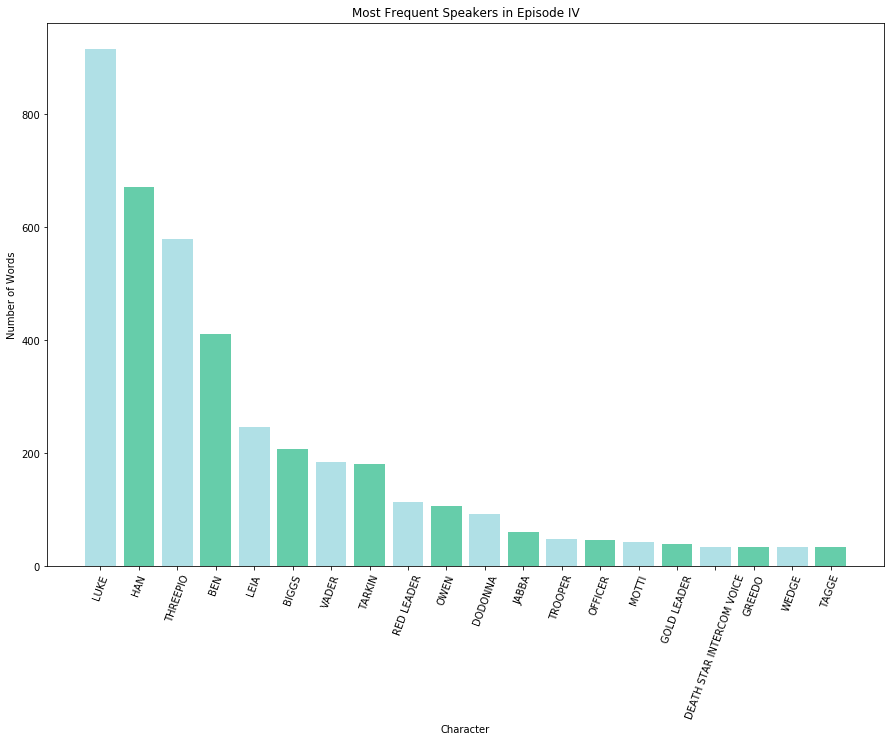

In [12]:
# initialize plot size
plt.figure(figsize=(15,10))
# plot top 20 sorted by descending numwords
plt.bar(ep4_speak.sort_values('numwords',ascending=False).head(20).character,
        ep4_speak.sort_values('numwords',ascending=False).head(20).numwords, 
        color=['powderblue','mediumaquamarine'])
# rotate names on x-axis
plt.xticks(rotation=70)
# name axes and plot
plt.xlabel('Character')
plt.ylabel('Number of Words')
plt.title('Most Frequent Speakers in Episode IV')
plt.show()

Some more characters who spoke a lot in this episode are Biggs Darklighter, Darth Vader, and Grand Moff Tarkin. As we can see in the plot, the difference between the amount of dialogue spoken by the top five characters and the amount of dialogue spoken by the next top five characters is pretty drastic. This is because the top five are really the main characters which the movie focuses on most of the time.

#### 3.1.2 Most Frequent Words

Wordclouds are intuitive data visualizations which depict the most frequent words said in a text in order of size. The most frequent word will be the biggest, while less frequent words are scaled smaller gradually. I will use a wordcloud to explore the frequent terms spoken in this text.

In [13]:
# convert all words into one string
ep4_allwords = ''
for key in dict4:
    for string in list(set(list(dict4[key].elements()))):
        ep4_allwords = ep4_allwords + ' ' + string

In [14]:
# load mask used for image outline
mask4 = np.array(Image.open('/Users/candacemckeag/Documents/School/111/Project/wordcloud_masks/rebel_alliance.png'))
mask4_colors = ImageColorGenerator(mask4)

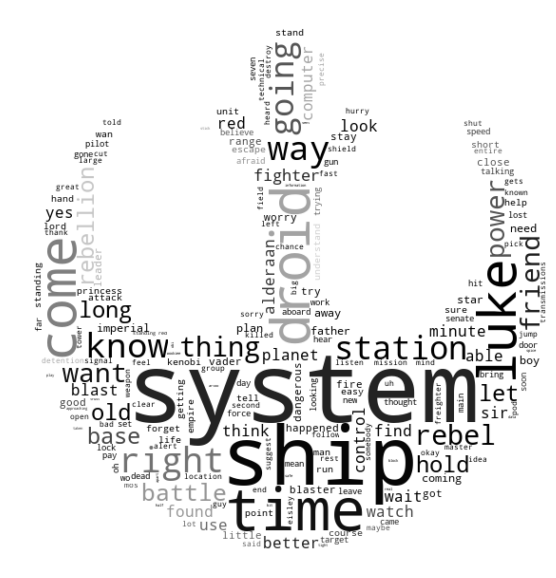

In [15]:
# initialize wordcloud object, let it find most frequent words
ep4_wordcloud = WordCloud(background_color='white',mask=mask4).generate(ep4_allwords)
# initialize plot figure
plt.figure(figsize=(10,10),edgecolor='black')
# show wordcloud
plt.imshow(ep4_wordcloud.recolor(color_func=mask4_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

Above we have a cool wordcloud of episode four in the shape of the Alliance Starbird, also known as the Phoenix, the insignia of the Rebel Alliance. Looking at the biggest terms in the cloud, the words *system*, *ship*, *droid*, *time*, and *luke* pop out and thus must be the most common words said by all characters in this episode.

### 3.2 Episode V

Now, I'll repeat the previous EDA but this time with episode five dialogue.

#### 3.2.1 Most Frequent Speakers

In [16]:
# initialize df
ep5_speak = pd.DataFrame()
# assign dict5 keys (all character names) to column
ep5_speak['character'] = dict5.keys()
numwords = []
for key in dict5:
    # sum values for each character
    numwords.append(sum(dict5[key].values()))
# add to df
ep5_speak['numwords'] = numwords

Let's look at the top five speakers in this episode.

In [17]:
ep5_speak.sort_values('numwords',ascending=False).head()

,character,numwords
1,HAN,613
4,THREEPIO,484
0,LUKE,399
3,LEIA,300
15,VADER,270


This episode's five most common speakers are Han Solo, C3PO, Luke, Princess Leia, and Darth Vader. This is really similar to episode four, except Obi-Wan has been replaced by Vader (due to plot developments of course). Let's see the rest of the most common speakers:

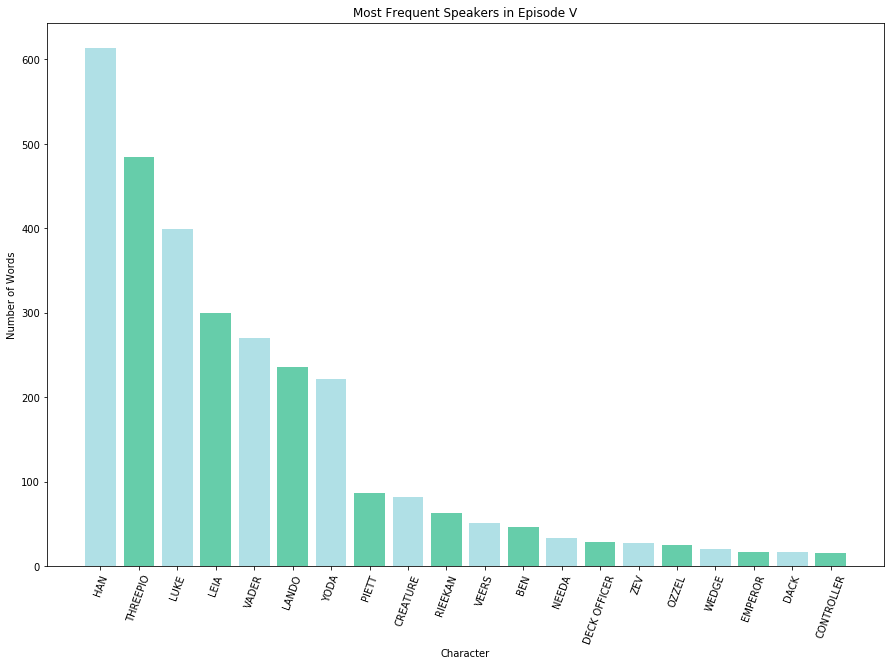

In [18]:
# initialize plot figure
plt.figure(figsize=(15,10))
# plot top twenty sorted by descending numwords
plt.bar(ep5_speak.sort_values('numwords',ascending=False).head(20).character,
        ep5_speak.sort_values('numwords',ascending=False).head(20).numwords, 
        color=['powderblue','mediumaquamarine'])
# plot details
plt.xticks(rotation=70)
plt.xlabel('Character')
plt.ylabel('Number of Words')
plt.title('Most Frequent Speakers in Episode V')
plt.show()

Again, pretty similar to the graph of episode four. However, something interesting to notice is that this time there seems to be more characters who share the majority of the speaking roles. The barplot tapers off and dramatically decreases after Yoda, so that the majority is shared by seven characters. In episode four, it was mostly the top four characters who shared the most dialogue, and Luke outnumbered others drastically.

#### 3.2.2 Most Frequent Words

Another wordcloud is made, this time for episode five.

In [19]:
# convert all words into one string
ep5_allwords = ''
for key in dict5:
    for string in list(set(list(dict5[key].elements()))):
        ep5_allwords = ep5_allwords + ' ' + string

In [20]:
# load new image outline
mask5 = np.array(Image.open('/Users/candacemckeag/Documents/School/111/Project/wordcloud_masks/yoda.png'))
mask5_colors = ImageColorGenerator(mask5)

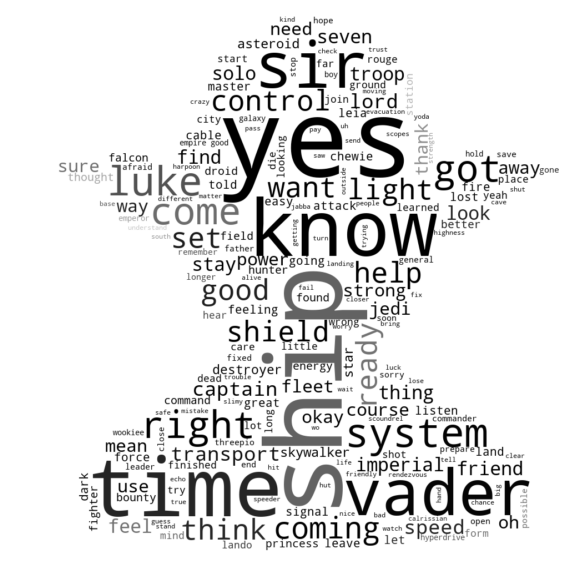

In [21]:
# create wordcloud object
ep5_wordcloud = WordCloud(background_color='white',mask=mask5).generate(ep5_allwords)
# show wordcloud
plt.figure(figsize=(10,10),edgecolor='black')
plt.imshow(ep5_wordcloud.recolor(color_func=mask5_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

This time, the wordcloud is in the shape of Jedi Master Yoda's head. The words that pop out the most this time are *yes*, *good*, and *know*, with *ship* and *time* tagging along from last episode.

### 3.3 Episode VI

Now, a final section of EDA for episode six.

#### 3.3.1 Most Frequent Speakers

In [22]:
# initialize df
ep6_speak = pd.DataFrame()
ep6_speak['character'] = dict6.keys()
numwords = []
# loop over characters in episode 6 to sum num words
for key in dict6:
    numwords.append(sum(dict6[key].values()))
ep6_speak['numwords'] = numwords

Now we can look at the top five most frequent speakers in episode six:

In [23]:
# top 5 ep 6 speakers
ep6_speak.sort_values('numwords',ascending=False).head()

,character,numwords
6,THREEPIO,443
14,HAN,420
10,LUKE,361
19,BEN,240
17,EMPEROR,233


We can again see a lot of the same main characters as the previous two episodes, but this time Emperor Palpatine is included in the bunch.

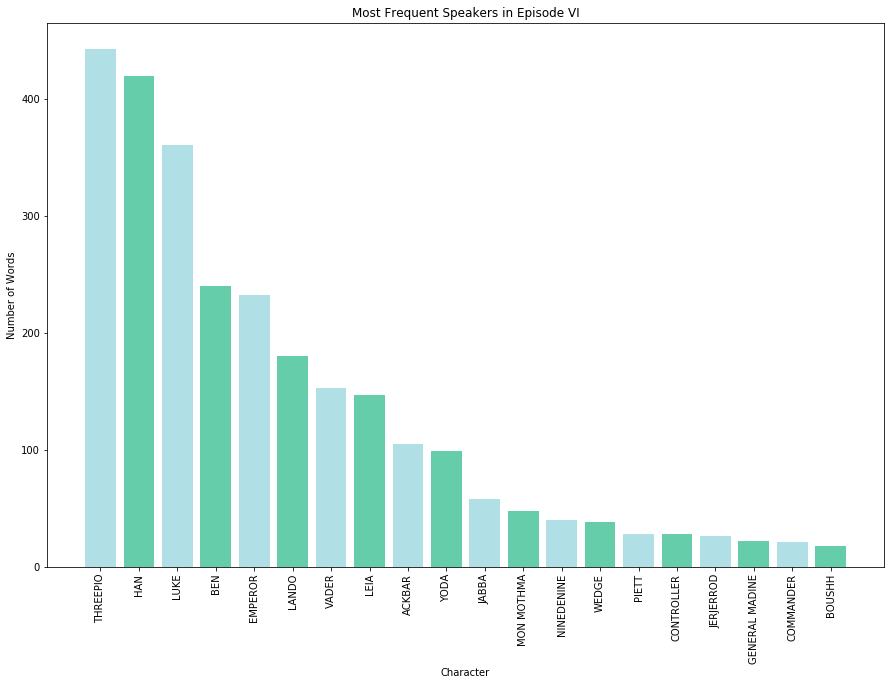

In [24]:
# initialize top 20 barplot
plt.figure(figsize=(15,10))
plt.bar(ep6_speak.sort_values('numwords',ascending=False).head(20).character,
        ep6_speak.sort_values('numwords',ascending=False).head(20).numwords, 
        color=['powderblue','mediumaquamarine'])
plt.xticks(rotation='vertical')
plt.xlabel('Character')
plt.ylabel('Number of Words')
plt.title('Most Frequent Speakers in Episode VI')
plt.show()

The barplot is unsurprising and highly similar to the past two barplots. This time, though, C3PO takes the lead and Admiral Ackbar has made it close to the top.

#### 3.3.2 Most Frequent Words

One final wordcloud for epsiode 6:

In [25]:
# convert all words into one string
ep6_allwords = ''
for key in dict6:
    for string in list(set(list(dict6[key].elements()))):
        ep6_allwords = ep6_allwords + ' ' + string

In [26]:
# load vader mask
mask6 = np.array(Image.open('/Users/candacemckeag/Documents/School/111/Project/newvader').convert("RGB"))
mask6_colors = ImageColorGenerator(mask6)

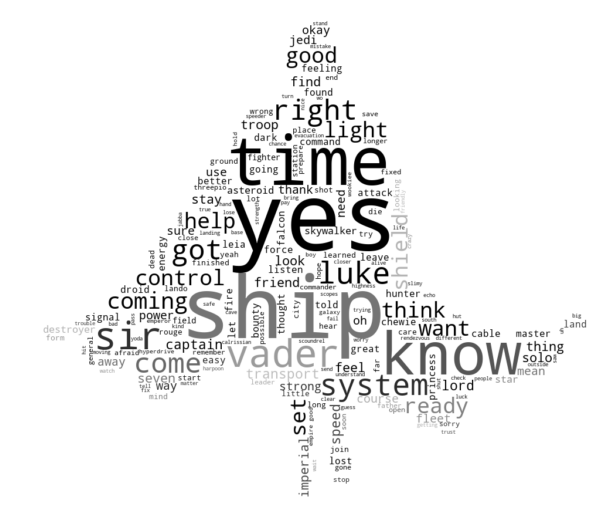

In [27]:
# create wordcloud object
ep5_wordcloud = WordCloud(background_color='white',mask=mask6).generate(ep5_allwords)
plt.figure(figsize=(10,10),edgecolor='black')
# show wordcloud
plt.imshow(ep5_wordcloud.recolor(color_func=mask6_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

As seen in the Darth Vader's silhouette, we see common words similar to the past two episodes: *ship*, *yes*, *time*, *know*, and *good*. This concludes the exploratory data analysis section.

## 4 Feature Engineering

The next step in building this machine learning model is to extract features from the text and convert them to numerical values so that the model can learn from them.

As said in the introduction, my goal with this project is to build a model which can predict whether a line from the movie was said by a character from the Empire or Rebels. Since the movies are mostly based on the struggle of the Rebels, the scenes usually focus on these characters. Thus, there is quite a lack of dialogue from characters with the Empire. In order to balance out the dataset, I sample from the dataset only the dialogue spoken by the top three Rebel characters.

In [28]:
allspeak = pd.concat([ep4_speak,ep5_speak,ep6_speak])

In [29]:
top = list(allspeak.groupby(['character']).sum().sort_values('numwords',ascending=False).head(3).index)
top

['HAN', 'LUKE', 'THREEPIO']

As seen above, the top three characters are all Rebels: Han Solo, Luke, and C3PO. To balance out the dataset with Empire characters, I am going to extract as many top Empire characters as I can who carry adequate importance in the movies. I am able to get twelve, as seen in the list *top_emp* below.

In [30]:
# top three rebel characters
top_reb = ['HAN','LUKE','THREEPIO']
# top 12 empire characters
top_emp = ['VADER','EMPEROR','TARKIN','PIETT','VEERS','MOTTI','DEATH STAR INTERCOM VOICE','TAGGE','NEEDA','JERJERROD','OZZEL','IMPERIAL OFFICER']

Now, I create a new dataset which consists of the dialogue spoken only by the fifteen characters above. I assign a binary column in this dataframe which describes Rebels with 1 and Empire characters with 0.

In [31]:
# dataframe such that character is in top_reb or top_emp
eps_side = eps.loc[eps['character'].isin(list(top_reb+top_emp))].reset_index().drop(columns='index')
# add side column with 1 for rebel and 0 for empire
eps_side['side'] = np.where(eps_side['character'].isin(top_reb), 1, 0)

In [32]:
eps_side.shape

(1540, 4)

In [33]:
eps_side.head()

,character,dialogue,episode,side
0,THREEPIO,Did you hear that? They've shut down the main...,Fourth,1
1,THREEPIO,We're doomed!,Fourth,1
2,THREEPIO,There'll be no escape for the Princess this time.,Fourth,1
3,THREEPIO,What's that?,Fourth,1
4,THREEPIO,I should have known better than to trust the l...,Fourth,1


I now proceed with feature extraction using this dataset.

### 4.1 Vectorization

The first feature extraction method I will use is Tf-idf vectorization using unigrams, bigrams, and trigrams with a limit of 1,000 features. This converts the words to a numeric value of term frequency divided by document frequency, since words which occur in many documents are not meaningful for distinguishing between them.

I am using bigrams and trigrams in my vectorizer because they add meaning and prediction power to the model. I limit the number of features to 1,000 because I do not want to overwhelm the model with too many features and thus lead to overfitting.

In [34]:
# create vectorizer
vectorizer = text.TfidfVectorizer(ngram_range=(1,3), max_features=1000, stop_words='english')
# fit vectorizer on dialogue column of data
vectorizer.fit(eps_side.dialogue)
# transform dialogue
features = vectorizer.transform(eps_side.dialogue)
# convert features to array for easier manipulation
dat = pd.DataFrame(features.toarray())

### 4.2 Sentiment Analysis

The next method of feature extraction I use is sentiment analysis in order to identify emotion or opinion content in the dialogue. In order to do this, I am using the Subjectivity Lexicon published by the University of Pittsburgh. This dataset consists of 8,222 words categorized by their polarity: positive, negative, or neutral. It also contains each words type (weak or strong subject) and part of speech.

In [35]:
# load csv file
sent_lex = pd.read_csv("/Users/candacemckeag/Documents/School/111/Project/sentiment.csv")
# drop unnecessary columns
sent_lex = sent_lex.drop(columns=['Unnamed: 0','V2','V5'])
# rename columns
sent_lex.columns = ['type','word','pos','polarity']
sent_lex.head()

,type,word,pos,polarity
0,type=weaksubj,word1=abandoned,pos1=adj,priorpolarity=negative
1,type=weaksubj,word1=abandonment,pos1=noun,priorpolarity=negative
2,type=weaksubj,word1=abandon,pos1=verb,priorpolarity=negative
3,type=strongsubj,word1=abase,pos1=verb,priorpolarity=negative
4,type=strongsubj,word1=abasement,pos1=anypos,priorpolarity=negative


I do some data cleaning to get rid of the "type=", "word1=", "pos1=", and "priorpolarity=" in each cell.

In [36]:
# loop over each column
for col in sent_lex:
    # loop over each row
    for j in range(len(sent_lex[col])):
        # find index of =
        ind = sent_lex[col][j].find('=')
        new = sent_lex[col][j][ind+1:]
        # replace cell w substring of existing cell after =
        sent_lex[col]=sent_lex[col].replace(sent_lex[col][j],new)

In [37]:
sent_lex.head()

,type,word,pos,polarity
0,weaksubj,abandoned,adj,negative
1,weaksubj,abandonment,noun,negative
2,weaksubj,abandon,verb,negative
3,strongsubj,abase,verb,negative
4,strongsubj,abasement,anypos,negative


Now that the data is in a nice format, I can proceed with this feature extraction. For each quote, I will add three values to the dataset: *positive*, *negative*, and *neutral*. Each of these values corresponds to the percent of words (converted to lemmas, ignoring stop words) in the quote that are in the sentiment lexicon and that are assigned that specific polarity value.

In [38]:
# initialize column values
positive=[]
negative=[]
neutral=[]
# loop over each quote
for quote in eps_side.dialogue:
    words = list(nlp(quote))
    lemmas = []
    # convert words to lemmas
    for word in words:
        if (word.is_stop == False) and (word.is_punct == False) and (word.is_space == False):
            lemmas.append(str(word.lemma_))
    # if there are any lemmas in the quote
    if lemmas != []:
        p=0
        ng=0
        nt=0
        # loop over each lemma
        for lemma in lemmas:
            # if the lemma is in the lexicon
            if lemma in list(sent_lex.word):
                ind = sent_lex.index[sent_lex['word']==lemma].tolist()[0]
                # add 1 to the polarity value count it corresponds to
                if sent_lex.polarity[ind] =='positive':
                    p+=1
                if sent_lex.polarity[ind] =='negative':
                    ng+=1
                if sent_lex.polarity[ind] =='neutral':
                    nt+=1
        # append percent of polarity value to corresponding list
        positive.append(p/len(lemmas))
        negative.append(ng/len(lemmas))
        neutral.append(nt/len(lemmas))
    # if there are no lemmas in the quote append 0
    else:
        positive.append(0)
        negative.append(0)
        neutral.append(0)

In [39]:
# add values to features df
dat['positive'] = positive
dat['negative'] = negative
dat['neutral'] = neutral

Now that I have extracted the subjective sentiment of each word in each quote, let's take a look at the values in the dataset:

In [40]:
dat.head()

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,positive,negative,neutral
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.222222,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,0.111111


Peeking at the first five rows, we can see the *positive*, *negative*, and *neutral* values consist of percents. Note that it is okay that the values don't add up to one, because not all words in the dialogue are in the subjectivity lexicon.

### 4.3 Named Entity Recognition

Next, I will use Named Entity Recognition (NER) in spacy. From Wikipedia, NRE is "a subtask of information extraction that seeks to locate and classify named entity mentions in unstructured text into pre-defined categories such as the person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc." I want to add this feature to the data because there might be a relationship between how many entities are mentioned by a a character and their side in the movie.

In [41]:
entities = []
# loop over each quote
for quote in eps_side.dialogue:
    doc = nlp(quote)
    entcount=0
    # count how many entities are mentioned in the quote
    for ent in doc.ents:
        entcount = entcount + 1
    # append proportion of tokens which are entities to list
    if entcount > 0:
        entities.append(entcount/len(doc))
    else:
        entities.append(0)

In [42]:
dat['entities'] = entities

In [43]:
dat.head()

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,positive,negative,neutral,entities
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.222222,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,0.111111,0.052632


As we can see above, the *entities* column consists of percentages which correspond to how many words in that quote are entities.

### 4.4 Topic Modeling

The next and final feature extraction method I will use is topic modeling to find the abstract topics that occur in the dialogue. This should be very helpful to the model since there should be a noticeable difference in what is discussed by the Rebels and the Empire.

In [44]:
# create model using 10 topics
nmf_model = NMF(n_components=10)
# fit on just the vectorized features
nmf_model.fit(features.toarray())

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=10, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [45]:
# dataframe w topic-word association weights with word
topics = pd.DataFrame(nmf_model.components_.T, index=vectorizer.get_feature_names())
topics.head()

,0,1,2,3,4,5,6,7,8,9
aboard,0.000000,0.000000,0.000125,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.041281
academy,0.000000,0.002066,0.000000,0.0,0.002996,0.000000,0.009576,0.0,0.00000,0.014000
accepted,0.000000,0.000000,0.000000,0.0,0.001819,0.000000,0.010964,0.0,0.00000,0.000000
admiral,0.000000,0.000000,0.000000,0.0,0.126994,0.000000,0.040897,0.0,0.00000,0.000000
afraid,0.026263,0.027633,0.000000,0.0,0.000000,0.013175,0.005550,0.0,0.00491,0.028842


Now that the topics are defined and we can see which words are associated with each topic, let's look at what topics have been chosen by the model:

In [46]:
for i in topics.columns:
    print("Topic {} words: {}".format(i+1, list(topics[i].sort_values(ascending=False).head(10).index)))

Topic 1 words: ['oh', 'wait', 'leia', 'oh oh', 'oh artoo', 'sir', 'great', 'oh dear', 'dear', 'need']
Topic 2 words: ['going', 'way', 'going going', 'power', 'look', 'excuse', 'try', 'shut', 'artoo going', 'okay']
Topic 3 words: ['come', 'come come', 'come artoo', 'uh', 'threepio', 'let', 'didn', 'mission', 'great', 'big']
Topic 4 words: ['right', 'll right', 'coming', 'threepio', 'old', 'ship', 'right ll', 'better', 'rouge', 'hang']
Topic 5 words: ['yes', 'lord', 'yes lord', 'yes master', 'admiral', 'vader', 'lord vader', 'master', 'leia', 'dagobah']
Topic 6 words: ['artoo', 'artoo artoo', 'hang', 'oh artoo', 'careful', 'come artoo', 'way', 'artoo detoo', 'detoo', 'ohhh']
Topic 7 words: ['don', 'know', 'got', 've', 'think', 'don know', 've got', 'good', 'like', 'just']
Topic 8 words: ['chewie', 'okay', 'chewie chewie', 'wait', 'help', 'easy', 'stand', 'han', 'care', 'hey']
Topic 9 words: ['luke', 'master', 'master luke', 'luke luke', 'sir', 'leia', 'help', 'just', 'tell', 'rescue']
To

A lot of the topics concern a specific character, like "artoo","vader", or "chewie. Some are simply overlapping ngrams, like topic three with "come". We can also see that partial contractions have been included, such ass "ll" and "don". Now I can proceed with converting this information to numerical features. I will make a column for each of the ten topics. Each quotes value for these columns will be the percent of unigrams, bigrams, or trigrams in that quote that are associated with each topic.

In [47]:
quote_topics = []
# loop over quotes
for quote in eps_side.dialogue:
    # tokenize quote
    toks = tokenizer.tokenize(quote)
    # initialize topic sums
    top_sum = [0]*10
    for word in toks:
        # if word is in topic index, add word weights to sum
        if str(word) in list(topics.index):
            pcts = list(topics.loc[str(word)])
            top_sum = [(x + y) for (x, y) in zip(top_sum,pcts)]
    # same for bigrams, trigrams
    bigrams = list(nltk.ngrams(toks, 2))
    for bigram in bigrams:
        if str(bigram) in list(topics.index):
            pcts = list(topics.loc[str(word)])
            top_sum = [(x + y) for (x, y) in zip(top_sum,pcts)]
    trigrams = list(nltk.ngrams(toks, 3))
    for trigram in trigrams:
        if str(trigram) in list(topics.index):
            pcts = list(topics.loc[str(word)])
            top_sum = [(x + y) for (x, y) in zip(top_sum,pcts)]
    quote_topics.append(top_sum)

In [48]:
arr = np.asarray(quote_topics)
# create dataframe w topic weights
topdf = pd.DataFrame(arr, columns=['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9','topic10'])

In [49]:
# add topic df to existing features dataframe
dat = pd.concat([dat, topdf], axis=1)

In [50]:
dat.head()

,0,1,2,3,4,5,6,7,8,9,...,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052721,0.080200,0.013776,0.005721,0.033114,0.062936,0.105263,0.013309,0.022568,1.763397e-01
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.945460e-56
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028031,0.003446,0.008725,0.026294,0.002547,0.008801,0.092076,0.000000,0.001902,1.671764e-01
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020858,0.033526,0.000000,0.104310,0.000129,0.057930,0.110452,0.014151,0.003615,3.295594e-02


Concluding this feature extraction process, we can see that each topic value consists of the percent of words in a quote that are associated with that topic. This feature extraction has been fruitful and should be highly helpful in building a strong model.

## 5 Model Training

I chose four different multi-class classification algorithms to test to find which best fits the data: K-nearest-neighbors, Logistic Regression, Naive Bayes, and Random Forest. I chose these somewhat based on personal bias but also their praise for high performace. For each algorithm, I first tune the parameters to that which yields the optimal model by iteratively fitting it on the training set and choosing the best parameter. Then after the parameter is chosen, I define a new model with that parameter, fit it on the training data, and extract the performance metrics for later comparison against other models.

First, I need to split the data into a training and testing set, create a dataframe in which to place the model metric results, and finally define a function which saves and print the metrics for me.

In [51]:
x_train, x_test, y_train, y_test = train_test_split(dat, eps_side.side)

In [52]:
results=pd.DataFrame()

In [53]:
def modelMetrics(model):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(x_test)).ravel()
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    fpr = fp/(fp+tn)
    roc_auc = roc_auc_score(y_test, model.predict(x_test))
    alls = [tpr, tnr, roc_auc, accuracy_score(y_test, model.predict(x_test)),f1_score(y_test, model.predict(x_test)), matthews_corrcoef(y_test, model.predict(x_test))]
    print("Scores for model")
    print("True Positive Rate:", tpr)
    print("True Negative Rate:", tnr)
    print("AUC:", roc_auc)
    print("Classification accuracy:", accuracy_score(y_test, model.predict(x_test)))
    print("F1 score:", f1_score(y_test, model.predict(x_test)))
    print("Matthews coefficient:", matthews_corrcoef(y_test, model.predict(x_test)))
    return(alls)

### 5.1 K-Nearest-Neighbors

The first model I will try is the K-Nearest-Neighbors model which works by classifying an observation by a majority vote of its neighbors, with the observation being assigned to the class most common among its k nearest neighbors.

#### 5.1.1 Model Building

In [54]:
# create model object
knn_model = KNeighborsClassifier()

The most important parameter to tune in this algorithm is the number of neighbors with which to decide the classification.

In [55]:
# define parameter grid, test btwn 1 and 20 neighbors
knn_params = {'n_neighbors':list(range(1, 21))}
knn_grid = GridSearchCV(knn_model, knn_params, cv=5)
knn_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
# overall best score
print(knn_grid.best_score_)
# parameter which achieved best score
print(knn_grid.best_params_)

0.832034632034632
{'n_neighbors': 3}


The number of neighbors associated with the best performing model is five, so I will define the best KNN model with this parameter.

#### 5.1.2 Model Fitting & Metrics

In [59]:
# define best knn model
knn_model = KNeighborsClassifier(n_neighbors = 5)
# fit on training data
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [60]:
# use predefined function to print results
results['KNN'] = modelMetrics(knn_model)

Scores for model
True Positive Rate: 1.0
True Negative Rate: 0.15
AUC: 0.575
Classification accuracy: 0.8233766233766234
F1 score: 0.8997050147492626
Matthews coefficient: 0.35022015289811426


The TNR for this model is very disappointing. This is because the model produce a lot of false positives, meaning there were a lot of instances of the model predicting that a Rebel said a line but the line was actually spoken by an Empire character. This causes the AUC to be inadequate. 

### 5.2 Logistic Regression

Next, I'll build a logistic regression model which works by using a logistic function to model the binary dependent variable of *side*.

#### 5.2.1 Model Building

In [61]:
# create model object
log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)

For the logistic regression model, the key parameter to tune is the regularization strength. This is represented in the function by C, which is actually the inverse of regularization strength, with smaller values specifying stronger regularization strength. Regularization can be seen as a penalty against complexity, basically adding bias if the model suffers from high variance (i.e., it overfits the training data).

In [62]:
# define set of strengths to test
log_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_grid = GridSearchCV(log_model, log_params, cv=5)
log_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
# overall best score
print(log_grid.best_score_)
# parameter which achieved best score
print(log_grid.best_params_)

0.8891774891774892
{'C': 10}


The optimal parameter is C=10, implying that a regularization strength of 0.10 is best for training this model on this dataset.

#### 5.2.2 Model Fitting & Metrics

In [64]:
# define best logreg model
log_model = LogisticRegression(C=10, multi_class='multinomial', solver='lbfgs', max_iter=5000)
# fit on training data
log_model.fit(x_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [65]:
results['Logit'] = modelMetrics(log_model)

Scores for model
True Positive Rate: 0.9672131147540983
True Negative Rate: 0.4875
AUC: 0.7273565573770492
Classification accuracy: 0.8675324675324675
F1 score: 0.9204368174726989
Matthews coefficient: 0.5535600178874834


This model returned some decent metrics. We can see that the AUC and TNR in the logistic regression model is much better than that of the KNN model which is a good sign, and means that this model does not produce as many false positives. However, even though the TNR is higher it is still worrisome that it sits below 60%.

### 5.3 Naive Bayes

The multinomial Naive Bayes classifier is based on applying Bayes' theorem with strong (naive) independence assumptions between the features. For classification with discrete features, the multinomial distribution usually requires integer feature counts. In this case, there are a lot of fractional counts, so the strength of this model may not be impressive.

#### 5.3.1 Model Building

In [66]:
# create model object
nb_model = MultinomialNB()

In this model, I will tune *alpha*, the additive smoothing parameter which regularizes probability estimates such that no probability is ever set to be exactly zero, and the *fit_prior* parameter which tells the model whether to learn class prior probabilities or not.

In [67]:
nb_params = {'alpha':list(np.arange(0,1.0,0.01)),'fit_prior':[True,False]}
nb_grid = GridSearchCV(nb_model, nb_params, cv=5)
nb_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0..., 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99], 'fit_prior': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
# overall best score
print(nb_grid.best_score_)
# parameter which achieved best score
print(nb_grid.best_params_)

0.9004329004329005
{'alpha': 0.3, 'fit_prior': True}


The best smoothing parameter is 0.11, and I will be fitting a prior to this data.

#### 5.3.2 Model Fitting & Metrics

In [69]:
# create model obj
nb_model = MultinomialNB(alpha=0.11, fit_prior=True)
# fit model to training data
nb_model.fit(x_train, y_train)

MultinomialNB(alpha=0.11, class_prior=None, fit_prior=True)

In [70]:
results['NaiveBayes'] = modelMetrics(nb_model)

Scores for model
True Positive Rate: 0.9311475409836065
True Negative Rate: 0.575
AUC: 0.7530737704918032
Classification accuracy: 0.8571428571428571
F1 score: 0.9117174959871589
Matthews coefficient: 0.5416529129584531


The metrics for the Naive Bayes model are surprisingly somewhat impressive. This model has a higher TNR and AUC than the previous two models, so we are gradually getting rid of the false positives being produced by these models.

### 5.4 Random Forest

The final model to be tested is the Random Forest model, described by sci-kit learn as "a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting." This is a high-level algorithm and sometimes difficult to interpret, however has been known to produce great predictions.

#### 5.4.1 Model Building

In [71]:
# create model object
rf_model = RandomForestClassifier()

The key to building a strong Random Forest model is correctly tuning the number of trees in the forest. These trees are individual decision trees which take in attributes of an observation (branches) and create conclusions about the observation's target value (leaves).

In [72]:
# define parameter grid
rf_params = {'n_estimators':list(range(10,151,10))}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
# overall best score
print(rf_grid.best_score_)
# parameter which achieved best score
print(rf_grid.best_params_)

0.870995670995671
{'n_estimators': 90}


The optimal number of trees is 50.

#### 5.4.2 Model Fitting & Metrics

In [74]:
# define forest w 50 trees
rf_model = RandomForestClassifier(n_estimators = 50)
# fit on training data
rf_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
results['RandomForest'] = modelMetrics(rf_model)

Scores for model
True Positive Rate: 0.9770491803278688
True Negative Rate: 0.3375
AUC: 0.6572745901639344
Classification accuracy: 0.8441558441558441
F1 score: 0.9085365853658537
Matthews coefficient: 0.4497699688599179


This model has similar metrics to the others, but the TNR is disappointing and not as high as the Naive Bayes model. Thus, the AUC also suffers. Besides that, the TPR is very impressive (but probably because the model guesses Rebel most of the time).

### 5.5 Model Selection

#### 5.5.1 Metric Evaluation

Now, it's time to decide which model is truly the best for this dataset. Let's look at our dataframe of metric results.

In [76]:
results['metric'] = ['TPR','TNR','AUC','Accuracy','F1','Matthews']
results = results.set_index('metric')
results = results.transpose()
results

metric,TPR,TNR,AUC,Accuracy,F1,Matthews
KNN,1.000000,0.1500,0.575000,0.823377,0.899705,0.350220
Logit,0.967213,0.4875,0.727357,0.867532,0.920437,0.553560
NaiveBayes,0.931148,0.5750,0.753074,0.857143,0.911717,0.541653
RandomForest,0.977049,0.3375,0.657275,0.844156,0.908537,0.449770


Since I used multiple types of metrics to build this model, it is difficult to decide which one should be the deciding metric. Looking just at the dataframe, however, it is easy to see that I will not be choosing the KNN or the Random Forest models because their True Negative Rates are much too low.

Instead of choosing just one, I am going to average out each metric for each model and choose the model with the highest average metric.

In [77]:
results.mean(1)

KNN             0.633050
Logit           0.753933
NaiveBayes      0.761622
RandomForest    0.695714
dtype: float64

Logistic Regression has on average the highest metric score, so we will use this model for predictions.

#### 5.5.2 Model Interpretation

To peek inside the model and get some insight to what it's actually doing, we can look at the model coefficients of the words in the vectorizer.

In [103]:
coefs = pd.DataFrame({"Word": vectorizer.get_feature_names(), "Coef": LogisticRegression(C=10, multi_class='multinomial', solver='lbfgs', max_iter=5000).fit(features,eps_side.side).coef_[0]}).sort_values('Coef')

In [104]:
coefs.head()

,Word,Coef
537,lord,-4.370261
243,emperor,-3.723147
726,rebel,-3.225395
998,young,-3.179004
3,admiral,-2.857325


These are the words with most weight in an observation being classified as Empire. These all make a lot of sense, as 'lord' refers to Lord Vader, 'emperor' refers to Emperor Palpatine, and 'admiral' usually refers to Admiral Piett. It's interesting that 'rebel' makes the list, but this is probably because the Empire talks about the Rebels more often than the Rebels reference themselves. I am not entirely sure why 'young' appears on this list, but it could be from Darth Vader referring to Luke as 'young Skywalker.'

In [105]:
coefs.tail()

,Word,Coef
936,uh,2.092695
555,master luke,2.099143
607,oh,2.188179
23,artoo,2.279233
509,ll,2.404970


The words above are those most associated with quotes spoken by Rebel characters. There are characters referenced again, with 'master luke' and 'artoo' or R2D2. I think that 'uh' and 'oh' make the list because C3PO often stutters and says these. As for 'll', this is simply the second part of a contraction like "we'll" or "he'll". I think this carries a lot of weight (in fact, the most) simply because the Rebels speak more and take up most of the dataset. Because there is more Rebel dialogue, there is opportunity for more words to be said and thus more contractions. Not very exciting.

## 6 Prediction

The final step in this project is to write some code that utilizes the logistic regression model to predict the speaker of a user-inputted string of text.

### 6.1 Function Definition

The following function performs all of the previous feature extraction on a user-inputted quote so that the logistic regression model can perform its prediction.

In [78]:
def RebOrEmp():
    # input text
    quote = input("Give me a Star Wars quote: ")
    # vectorize
    quote_features = vectorizer.transform([quote])
    # convert features to array for easier manipulation
    quote_dat = pd.DataFrame(quote_features.toarray())

    # sentiment analysis
    words = list(nlp(quote))
    lemmas = []
    # convert words to lemmas
    for word in words:
        if (word.is_stop == False) and (word.is_punct == False) and (word.is_space == False):
            lemmas.append(str(word.lemma_))
    # if there are any lemmas in the quote
    if lemmas != []:
        p=0
        ng=0
        nt=0
        # loop over each lemma
        for lemma in lemmas:
            # if the lemma is in the lexicon
            if lemma in list(sent_lex.word):
                ind = sent_lex.index[sent_lex['word']==lemma].tolist()[0]
                # add 1 to the polarity value count it corresponds to
                if sent_lex.polarity[ind] =='positive':
                    p+=1
                if sent_lex.polarity[ind] =='negative':
                    ng+=1
                if sent_lex.polarity[ind] =='neutral':
                    nt+=1
        # append percent of polarity value to corresponding list
        qpositive = p/len(lemmas)
        qnegative = ng/len(lemmas)
        qneutral = nt/len(lemmas)
    # if there are no lemmas in the quote append 0
    else:
        qpositive = 0
        qnegative = 0
        qneutral = 0
    # add values to features df
    quote_dat['positive'] = qpositive
    quote_dat['negative'] = qnegative
    quote_dat['neutral'] = qneutral

    # named entity recognition
    qdoc = nlp(quote)
    qentcount=0
    # count how many entities are mentioned in the quote
    for ent in qdoc.ents:
        qentcount = qentcount + 1
    # append proportion of tokens which are entities to list
    if qentcount > 0:
        qentities = qentcount/len(qdoc)
    else:
        qentities = 0
    # add values to features df
    quote_dat['entities'] = qentities

    # topic modeling
    # tokenize quote
    qtoks = tokenizer.tokenize(quote)
    # initialize topic sums
    qtop_sum = [0]*10
    for word in qtoks:
        # if word is in topic index, add word weights to sum
        if str(word) in list(topics.index):
            pcts = list(topics.loc[str(word)])
            qtop_sum = [(x + y) for (x, y) in zip(qtop_sum,pcts)]
    # same for bigrams, trigrams
    bigrams = list(nltk.ngrams(qtoks, 2))
    for bigram in bigrams:
        if str(bigram) in list(topics.index):
            pcts = list(topics.loc[str(word)])
            qtop_sum = [(x + y) for (x, y) in zip(qtop_sum,pcts)]
    trigrams = list(nltk.ngrams(qtoks, 3))
    for trigram in trigrams:
        if str(trigram) in list(topics.index):
            pcts = list(topics.loc[str(word)])
            qtop_sum = [(x + y) for (x, y) in zip(qtop_sum,pcts)]
    # add to array
    qarr = np.asarray([qtop_sum])
    # create dataframe w topic weights
    qtopdf = pd.DataFrame(qarr, columns=['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9','topic10'])
    # concatenate
    quote_dat = pd.concat([quote_dat, qtopdf], axis=1)

    # predict
    prob = log_model.predict_proba(quote_dat)
    pred = log_model.predict(quote_dat)
    if pred == 1:
        print('"{}"'.format(quote),'is said by a Rebel, with {}% confidence.'.format(round(prob[0][1]*100,2)))
    else:
        print('"{}"'.format(quote),'is said by an Empire affiliate, with {}% confidence.'.format(round(prob[0][0]*100,2)))

### 6.2 Predictions

Now that the function is ready, we can call it with no arguments. It asks the user for a string, and once given it outputs a prediction of the alliance as well as the model's confidence in its prediction. I'll show some examples, and then leave it open for you to try it out.

In [79]:
RebOrEmp()

Give me a Star Wars quote: the death star will live on
"the death star will live on" is said by an Empire affiliate, with 76.32% confidence.


In [80]:
RebOrEmp()

Give me a Star Wars quote: i am just a farmboy from tatooine
"i am just a farmboy from tatooine" is said by a Rebel, with 92.18% confidence.


In [81]:
RebOrEmp()

Give me a Star Wars quote: i truly detest the empire
"i truly detest the empire" is said by a Rebel, with 91.71% confidence.


In [82]:
RebOrEmp()

Give me a Star Wars quote: i truly detest the rebels
"i truly detest the rebels" is said by an Empire affiliate, with 95.82% confidence.


In [ ]:
RebOrEmp()

## 7 Conclusion

### 7.1 Overall Process

In building this predictive model, I completed many tasks including exploratory data analysis, feature extraction, sentiment analysis, topic modeling, model selection, and model evaluation. Using the datasets of dialogue from the first three episodes of Star Wars, I built a logistic regression classifer which predicts the correct side affiliation about 87% of the time. I then created a function that streamlines the prediction process, telling the user whether a quote is or would be said by a Rebel or Empire affiliate as well as the probability with which the class was assigned.

### 7.2 Further Improvements

I think the clearest weakpoint of the model is its average strength in classifying Empire quotes. Based on the training and testing data, the model only correctly classified Empire characters about 60% of the time. I knew this was going to be an issue when I took my first look at the dataset and noticed the huge imbalance of the classes. Obviously the Star Wars movies focus on the Rebel side, so most of the dialogue is said by Rebels. Only about 15% of the sampled dataset belonged to the Empire after I narrowed the original dataset down to only Han Solo, Luke, and C3PO. I did try to use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes and perhaps obtain better metrics, but this resulted in a huge drop in every metric except True Negative Rate, and thus was not worth the loss. In order to surpass this, I would suggest obtaining the dialogue from more than just the first three episodes of Star Wars so that there is more Empire dialogue.

### 7.3 Potential Uses

I admit that this model does not have much practical or realistic use. However, it is interesting to conclude that there is a distinguishable enough difference between the words and sentiment used by the Rebels and the Empire that a computer is able to classify them with decent accuracy. Also, I think the RebOrEmp function is pretty cool and fun to play around with.

## 8 Appendix

### 8.1 References

* Star Wars Movie Scripts: https://www.kaggle.com/xvivancos/star-wars-movie-scripts
* Star Wars: https://en.wikipedia.org/wiki/Star_Wars
* Languages in Star Wars: https://en.wikipedia.org/wiki/Languages_in_Star_Wars
* Professor Barnwell’s lecture slides
* University of Pittsburgh's Subjectivity Lexicon: http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/
* Named-entity recognition: https://en.wikipedia.org/wiki/Named-entity_recognition
* Naive Bayes classifier: https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes
* Random Forest Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 8.2 Acknowledgements

I would like to thank Professor Barnwell, Phil Rogers, and the Linguistics department for providing me with the opportunity and wildly helpful resources for learning natural language processing and its use in machine learning. It is a shock that this kind of course is not readily offered to all Statistical Science majors. The topics I learned in this class are not only intriguing but will also be immensely useful in my future career.

I would also like to thank Grant Nolasco for giving me the idea to predict whether dialogue was spoken by a Rebel or Empire affiliate.